In [ ]:
!pip install gcsfs --quiet
!pip install dask[complete] --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.6 MB/s eta 0:00:00


In [20]:
from google.colab import files
from tqdm import tqdm
# uploaded = files.upload()
import gcsfs
import os
import pandas as pd
import glob
import dask.dataframe as dd
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from dask.diagnostics import ProgressBar
import numpy as np
import networkx as nx
import itertools
import random

In [2]:
# adding a progress bar for every code run
ProgressBar().register()

In [3]:
# uploaded = files.upload()
fs = gcsfs.GCSFileSystem(project='zippy-avatar-454716-s7',
                         token='/content/zippy-avatar-454716-s7-6ce326d91b28.json')

In [4]:
# to check the totol number of files in the gcp bucket
files = fs.ls('github-networks-bucket/feb_apr_2020_export')
print(f"Total files: {len(files)}")
print(files[:5])  # Show a few filenames

FileNotFoundError: b/github-networks-bucket/o/feb_apr_2020_export

In [5]:
with fs.open(files[0]) as f:
    df = pd.read_parquet(f)

df.head()

,id,type,created_at,actor,repo,payload
0,12088780983,IssuesEvent,2020-04-18 20:25:51,Dbzman,AOEpeople/gitlab-crucible-bridge,"{""action"":""closed"",""issue"":{""url"":""https://api..."
1,11502079848,IssuesEvent,2020-02-12 18:24:23,MikeRalphson,APIs-guru/openapi-directory,"{""action"":""closed"",""issue"":{""url"":""https://api..."
2,11692935302,IssuesEvent,2020-03-05 23:49:06,hol353,APSIMInitiative/ApsimX,"{""action"":""closed"",""issue"":{""url"":""https://api..."
3,11997965293,IssuesEvent,2020-04-08 19:32:53,IvoPaunov,AdExNetwork/adex-platform,"{""action"":""closed"",""issue"":{""url"":""https://api..."
4,11779449716,IssuesEvent,2020-03-16 18:02:47,Alex-302,AdguardTeam/AdguardFilters,"{""action"":""closed"",""issue"":{""url"":""https://api..."


In [ ]:
# Create a local folder to save the files
local_dir = "/content/feb_apr_2020_export"
os.makedirs(local_dir, exist_ok=True)

# Download and save all files from GCS
# for i, file in enumerate(files):
#     local_path = os.path.join(local_dir, os.path.basename(file))
#     # print(f"Downloading file {i+1}/{len(files)}: {local_path}")

#     with fs.open(file, 'rb') as fsrc, open(local_path, 'wb') as fdst:
#         fdst.write(fsrc.read())

for file in tqdm(files, desc="Downloading files", unit="file"):
    local_path = os.path.join(local_dir, os.path.basename(file))
    with fs.open(file, 'rb') as fsrc, open(local_path, 'wb') as fdst:
        fdst.write(fsrc.read())

In [5]:
parquet_files = glob.glob("/content/feb_apr_2020_export/*.parquet")
print(len(parquet_files))

5000


In [6]:
# Using dask to create a lazy df
df_feb_apr_20 = dd.read_parquet("/content/feb_apr_2020_export/*.parquet")

In [7]:
df_feb_apr_20.head()

[########################################] | 100% Completed | 303.71 ms


,id,type,created_at,actor,repo,payload
0,12088780983,IssuesEvent,2020-04-18 20:25:51,Dbzman,AOEpeople/gitlab-crucible-bridge,"{""action"":""closed"",""issue"":{""url"":""https://api..."
1,11502079848,IssuesEvent,2020-02-12 18:24:23,MikeRalphson,APIs-guru/openapi-directory,"{""action"":""closed"",""issue"":{""url"":""https://api..."
2,11692935302,IssuesEvent,2020-03-05 23:49:06,hol353,APSIMInitiative/ApsimX,"{""action"":""closed"",""issue"":{""url"":""https://api..."
3,11997965293,IssuesEvent,2020-04-08 19:32:53,IvoPaunov,AdExNetwork/adex-platform,"{""action"":""closed"",""issue"":{""url"":""https://api..."
4,11779449716,IssuesEvent,2020-03-16 18:02:47,Alex-302,AdguardTeam/AdguardFilters,"{""action"":""closed"",""issue"":{""url"":""https://api..."


In [ ]:
# event types and counts between Febuary to April 2020
df_feb_apr_20['type'].value_counts().compute()

[########################################] | 100% Completed | 31.00 s


,count
type,
WatchEvent,11611722
ForkEvent,4722166
PullRequestEvent,14860562
PullRequestReviewCommentEvent,3903761
CreateEvent,10609250
GollumEvent,329948
MemberEvent,143513
IssueCommentEvent,11809479
PushEvent,29028704


RQ1 - How did developer collaboration activity on GitHub change during COVID-19 pandemic compared to months before it?

In [8]:
# making a copy of data for analysis
df_collab = df_feb_apr_20.copy()

# dropping payload column as it is not needed for collaboration analysis
df_collab = df_collab.drop('payload', axis=1)

In [83]:
# Ensure 'created_at' is datetime
df_collab['created_at'] = dd.to_datetime(df_collab['created_at'])

# Extract weekly period
df_collab['week'] = df_collab['created_at'].dt.to_period('W').dt.start_time

Event Type Analysis

In [ ]:
# Ensure 'created_at' is datetime
df_collab['created_at'] = dd.to_datetime(df_collab['created_at'])

# Extract weekly period
df_collab['week'] = df_collab['created_at'].dt.to_period('W').dt.start_time

# Group by week and event type, count events
weekly_event_counts = (
    df_collab.groupby(['week', 'type'])
    .size()
    .compute()
    .unstack(fill_value=0)
    .sort_index()
)

# Display table
weekly_event_counts.head(10)  # Shows first 10 weeks as example

[########################################] | 100% Completed | 95.17 s


type,CommitCommentEvent,CreateEvent,DeleteEvent,ForkEvent,GollumEvent,IssueCommentEvent,IssuesEvent,MemberEvent,PublicEvent,PullRequestEvent,PullRequestReviewCommentEvent,PushEvent,ReleaseEvent,WatchEvent
week,,,,,,,,,,,,,,
2020-01-27,4507,113734,41386,65392,5397,115223,45043,1465,0,137188,28138,443871,4114,167651
2020-02-03,24456,547411,239817,312619,27300,765896,287563,11876,4,829493,266682,1955850,28867,759812
2020-02-10,25242,635501,281757,325974,22971,818542,296634,10532,1,929529,273258,2000450,30734,849291
2020-02-17,23404,580814,249272,339399,22113,782725,295696,10634,1,826883,264564,1986392,29495,847033
2020-02-24,23949,969167,406014,345896,23934,945486,308765,10524,0,1358734,272717,2041215,30746,855540
2020-03-02,23287,761211,410300,359902,25277,954020,299922,12077,0,1180378,284623,2126306,30895,874191
2020-03-09,24565,1161152,294864,358424,21005,851271,314685,10292,0,1444793,287667,2130474,29842,858583
2020-03-16,28544,800229,302125,356847,22757,854543,308029,13260,2,1068162,308615,2195513,34081,866162
2020-03-23,32865,714782,349339,379115,27172,963958,344800,13170,1,1069998,331725,2368464,41028,919947


In [ ]:
# calculating percentage changes
weekly_percent_changes = weekly_event_counts.pct_change() * 100

# dropping the first row
weekly_percent_changes = weekly_percent_changes.iloc[1:]

# replacing inf values with NaN
weekly_percent_changes.replace([np.inf, -np.inf], np.nan, inplace=True)

# rounding the percentages
weekly_percent_changes = weekly_percent_changes.round(2)

weekly_percent_changes.head(10)

type,CommitCommentEvent,CreateEvent,DeleteEvent,ForkEvent,GollumEvent,IssueCommentEvent,IssuesEvent,MemberEvent,PublicEvent,PullRequestEvent,PullRequestReviewCommentEvent,PushEvent,ReleaseEvent,WatchEvent
week,,,,,,,,,,,,,,
2020-02-03,442.62,381.31,479.46,378.07,405.84,564.71,538.42,710.65,NaN,504.64,847.76,340.63,601.68,353.21
2020-02-10,3.21,16.09,17.49,4.27,-15.86,6.87,3.15,-11.32,-75.00,12.06,2.47,2.28,6.47,11.78
2020-02-17,-7.28,-8.61,-11.53,4.12,-3.74,-4.38,-0.32,0.97,0.00,-11.04,-3.18,-0.70,-4.03,-0.27
2020-02-24,2.33,66.86,62.88,1.91,8.23,20.79,4.42,-1.03,-100.00,64.32,3.08,2.76,4.24,1.00
2020-03-02,-2.76,-21.46,1.06,4.05,5.61,0.90,-2.86,14.76,NaN,-13.13,4.37,4.17,0.48,2.18
2020-03-09,5.49,52.54,-28.13,-0.41,-16.90,-10.77,4.92,-14.78,NaN,22.40,1.07,0.20,-3.41,-1.79
2020-03-16,16.20,-31.08,2.46,-0.44,8.34,0.38,-2.12,28.84,NaN,-26.07,7.28,3.05,14.20,0.88
2020-03-23,15.14,-10.68,15.63,6.24,19.40,12.80,11.94,-0.68,-50.00,0.17,7.49,7.88,20.38,6.21
2020-03-30,23.88,89.05,5.06,3.22,0.22,6.51,4.48,-4.02,200.00,59.71,4.34,3.33,-7.23,3.39


- There was an high increase across all events in the first observed week. In next weeks from mid Feb to early March, the activity is midly fluctuated but mostly stable and main collaborative events are stable. From Mid march there is a noticeable upward shift in collaborations oriented events like PRs with 59.71% increase and Issue comments with 12.8 and 6.5 % increases. This aligns with global shifts towards remote work due to lockdowns.

Collaboration Intensity Metrics
-   1) Average Number of comments per Issue/PR on weekly basis

In [ ]:
# making a df for only collaborative comment related events
comments_df = df_collab[df_collab['type'].isin(['IssueCommentEvent', 'PullRequestReviewCommentEvent'])]

# changing the created_at column to datetime format
comments_df['created_at'] = dd.to_datetime(comments_df['created_at'])

# making a weekly aggregation of comment events
weekly_comments = comments_df.groupby(comments_df['created_at'].dt.to_period('W').dt.start_time).size().compute()

[########################################] | 100% Completed | 84.28 s


In [ ]:
# weekly aggregation of issues and PRs opened
issues_prs_df = df_collab[df_collab['type'].isin(['IssuesEvent', 'PullRequestEvent'])]

# changing to datetime and grouping by and computing
issues_prs_df['created_at'] = dd.to_datetime(issues_prs_df['created_at'])
weekly_issues_prs = issues_prs_df.groupby(issues_prs_df['created_at'].dt.to_period('W').dt.start_time).size().compute()

[########################################] | 100% Completed | 94.04 s


In [ ]:
# average number of comments per issue/PRs
avg_comments_per_issue_pr = (weekly_comments / weekly_issues_prs).round(2)

avg_comments_per_issue_pr

,0
created_at,
2020-04-27,0.77
2020-03-02,0.84
2020-03-09,0.65
2020-03-16,0.85
2020-04-13,0.85
2020-03-23,0.92
2020-02-17,0.93
2020-01-27,0.79
2020-04-06,0.91


-   2) Number of Unique contributors per repository per week  
It shows how many developers actively contributed on repositories weekly.  
So, this is the average number of unique contributors per repo for each week

In [ ]:
df_contributors = df_collab[['week', 'repo', 'actor']]
df_contributors = df_contributors.repartition(npartitions=100)
df_contributors = df_contributors.groupby(['week', 'repo'])['actor']

# counting unique contributors per repo each week
weekly_contributors_per_repo = (
    df_contributors.nunique()
    .reset_index()
    .rename(columns={'actor': 'unique_contributors'})
    .compute()
)

# getting weekly average accross repos
avg_weekly_contributions = weekly_contributors_per_repo.groupby('week')['unique_contributors'].mean().round(2)

avg_weekly_contributions

[########################################] | 100% Completed | 154.85 s


,unique_contributors
week,
2020-01-27,1.85
2020-02-03,2.51
2020-02-10,2.37
2020-02-17,2.60
2020-02-24,2.25
2020-03-02,2.32
2020-03-09,1.97
2020-03-16,2.34
2020-03-23,2.60


The average contributions were stable before the start of the lockdown and then we can see a increase in contributions post lockdown.

Network Analysis
RQ2 - What difference can be observed in the structure of collaboration networks before and after pandemic?

In [9]:
# selecting required columns only
df_network = df_collab[['created_at', 'repo', 'actor']]

# can use repartition if dask is slow


In [10]:
# creating a month column to separate the data by month
df_network['created_at'] = dd.to_datetime(df_network['created_at'])
df_network['month'] = df_network['created_at'].dt.to_period('M').dt.to_timestamp()

In [11]:
# filtering by month
df_feb = df_network[(df_network['month'] == '2020-02-01')].compute()
df_mar = df_network[(df_network['month'] == '2020-03-01')].compute()
df_apr = df_network[(df_network['month'] == '2020-04-01')].compute()

[########################################] | 100% Completed | 75.31 s
[########################################] | 100% Completed | 76.46 s
[########################################] | 100% Completed | 74.67 s


In [13]:
# funtion to build a graph
def build_graph(df_month):
  G = nx.Graph()
  grouped = df_month.groupby('repo')['actor'].apply(list)

  for devs in tqdm(grouped, desc='Building Graph'):
    # can add a cap to stop at repos having more than 200 devs
    # if len(devs) > 1 and len(devs) < 200:
    if len(devs) > 1:
      # slightly faster to use itertools than using nested loop
      G.add_edges_from(itertools.combinations(devs, 2))
      # for i in range(len(devs)):
        # for j in range(i+1, len(devs)):
          # G.add_edge(devs[i], devs[j])

  return G

In [14]:
# function to calculate network metrics
# def network_metrics(G):
#   density = nx.density(G)
#   avg_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
#   clustering = nx.average_clustering(G)
#   return density, avg_degree, clustering

In [ ]:
# Feb_G = build_graph(df_feb)
# Mar_G = build_graph(df_mar)
# Apr_G = build_graph(df_apr)

In [12]:
# creating a new graph building function, to separate the months data to weeks and build a dictionary
def weekly_graph_build(df_month):
  df_month['week'] = df_month['created_at'].dt.to_period('W').dt.start_time

  weeks = df_month['week'].unique()

  weekly_graphs = {}

  for week in tqdm(weeks, desc='Building graph'):
    df_week = df_month[df_month['week'] == week]

    grouped = df_week.groupby('repo')['actor'].apply(list)

    G = nx.Graph()

    for devs in grouped:
      if len(devs) > 1:
        G.add_edges_from(itertools.combinations(devs, 2))

    weekly_graphs[week] = G

  return weekly_graphs

In [21]:
# metrics for weekly graphs
def calculate_graph_metrics(G):
  if G.number_of_nodes() == 0:
    return (0, 0, 0)

  density = nx.density(G)
  degree_avg = sum(dict(G.degree()).values()) / G.number_of_nodes()
  # clustering = nx.average_clustering(G)

  if G.number_of_nodes() > 1000:
    sample_nodes = random.sample(list(G.nodes()), 1000)
  else:
    sample_nodes = list(G.nodes())

  clustering = nx.average_clustering(G, nodes = sample_nodes)


  return (density, degree_avg, clustering)

In [14]:
# getting a collective metrics by adding all the weekly ones
def metrics_summary(graphs):
  results = []

  for week, G in graphs.items():
    density, degree_avg, clustering = calculate_graph_metrics(G)
    results.append((week, density, degree_avg, clustering))

  metrics_df = pd.DataFrame(results, columns = ['Week', 'Density', 'Average Degree', 'Clustering Coeff'])
  metrics_df = metrics_df.sort_values('Week')

  return metrics_df

In [ ]:
# Febuary graph
feb_weekly_graph = weekly_graph_build(df_feb)

In [25]:
# calculating feb 2020 metrics
feb_weekly_metrics = metrics_summary(feb_weekly_graph)

feb_weekly_metrics

,Week,Density,Average Degree,Clustering Coeff
4,2020-01-27,0.000229,39.205873,0.622354
3,2020-02-03,0.000254,170.316073,0.711287
0,2020-02-10,0.000223,155.300791,0.727857
2,2020-02-17,0.000294,210.372562,0.704667
1,2020-02-24,0.000273,184.913374,0.704517


Based on the results from the network graph from Feb 2020 -  
- Network density tells the ratio of existing connections to the total possible connections between all nodes. So A higher density means more developers are directly collaborating with others and vice versa. We can see based on weekly graph in Feb 2020, the network density remains low but increases slightly, which indicates more overall interconnections.
- Average degree indicates how collaborative developers are on average. Higher values mean devs are involved with more peers. We can see a sharp increase in average degree, which indicates significant increase in cross-developer collaborations.
- Clustering coefficient indicates a degree to which a developer's collaboration also collaborate with one another. So, high coeff indicates tight knit collaboration group. It can be seen the coeff stays high at 0.7 and more almost all the time, so the developers are working in tightly linked groups.

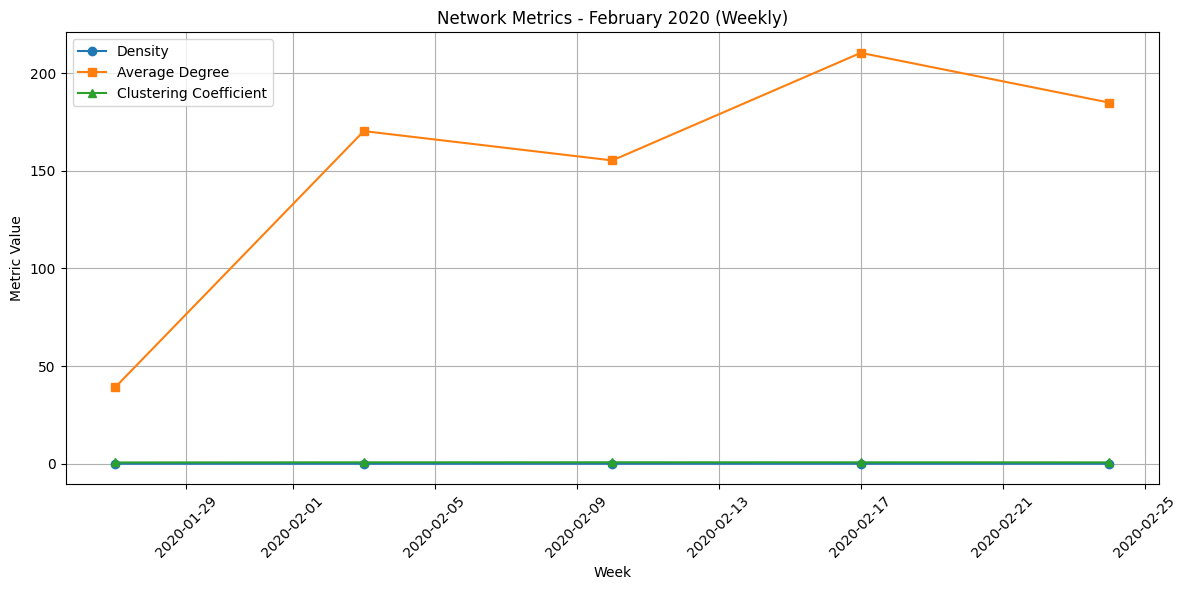

In [23]:
# making a plot to visualize feb 2020 network metrics
plt.figure(figsize = (12, 6))

plt.plot(feb_weekly_metrics['Week'], feb_weekly_metrics['Density'], marker='o', label='Density')
plt.plot(feb_weekly_metrics['Week'], feb_weekly_metrics['Average Degree'], marker='s', label='Average Degree')
plt.plot(feb_weekly_metrics['Week'], feb_weekly_metrics['Clustering Coeff'], marker='^', label='Clustering Coefficient')

plt.title('Network Metrics - February 2020 (Weekly)')
plt.xlabel('Week')
plt.ylabel('Metric Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()

Plotting a sample of network graph - 1st week of Feb 2020

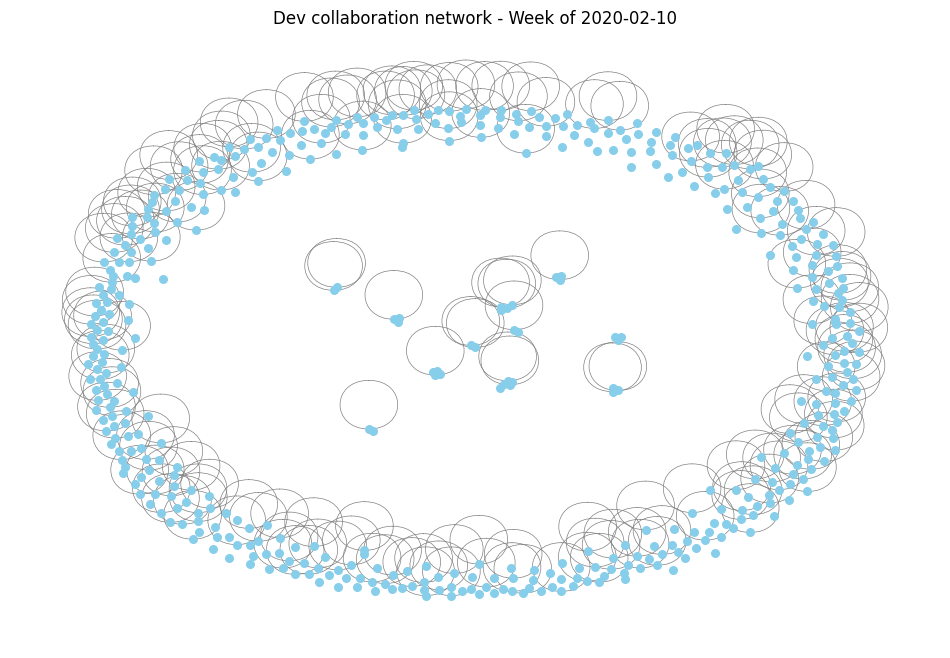

In [32]:
sample_week = list(feb_weekly_graph.keys())[0]
G = feb_weekly_graph[sample_week]

# taking a sample of nodes
sample_nodes = random.sample(list(G.nodes()), 500)
H = G.subgraph(sample_nodes)

plt.figure(figsize = (12, 8))
pos = nx.spring_layout(H, seed = 42)
nx.draw_networkx_nodes(H, pos, node_size=30, node_color="skyblue")
nx.draw_networkx_edges(H, pos, edge_color="gray", width=0.5)
plt.title(f"Dev collaboration network - Week of {sample_week.date()}")
plt.axis('off')
plt.show()

Looks like collaboration is sparse, but there are dense sub clusters. Many nodes in small groups indicates small scale collaborations.
Need to work on using different layout algorithm.

MISC

In [ ]:
# getting statistics on core colabs only
collab_events = ["PullRequestEvent", "IssueCommentEvent", "PullRequestReviewCommentEvent", "IssuesEvent"]
df_collab_only = df_collab[df_collab["type"].isin(collab_events)]

In [ ]:
# checking total colab events
df_collab_only.shape[0].compute()

[########################################] | 100% Completed | 413.04 s


34817324

In [ ]:
#df_collab_only = df_collab[df_collab['type'].isin(collab_events)]
weekly_avg_collab_events = (
    df_collab_only.groupby(df_collab_only['created_at'].dt.to_period('W'))
    .size()
    .mean()
    .compute()
)

[########################################] | 100% Completed | 175.96 s


In [ ]:
weekly_avg_collab_events

np.float64(2486951.714285714)

In [ ]:
# change the created_at column to date time format
df_collab['created_at'] = dd.to_datetime(df_collab['created_at'])

reparted = df_collab.repartition(npartitions=100)
# re sampling by 1 week to group all events into weekly bins

reparted = reparted.set_index('created_at')

event_volume = reparted.resample('W').size().compute()

[########################################] | 100% Completed | 11m 44s
[########################################] | 100% Completed | 402.32 s
[########################################] | 100% Completed | 431.96 s
[########################################] | 100% Completed | 512.72 s


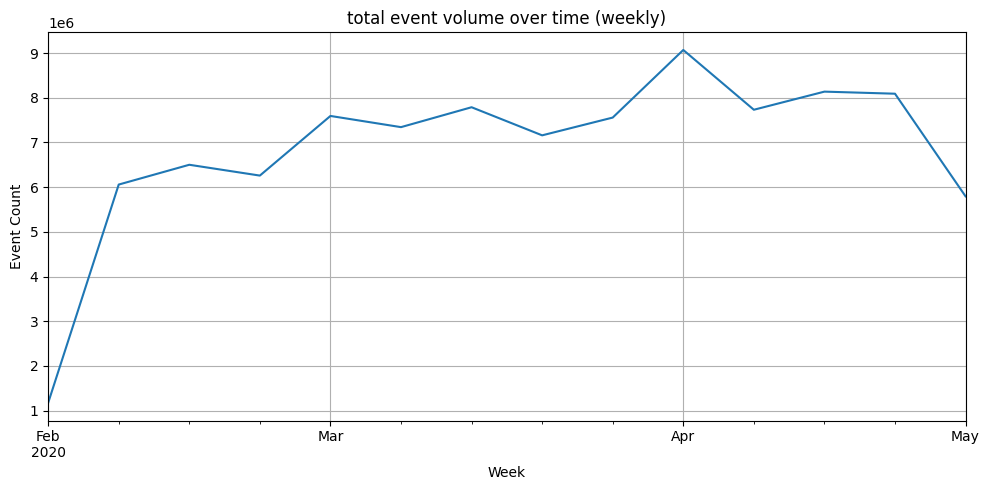

In [ ]:
plt.figure(figsize=(10, 5))
event_volume.plot(kind = 'line')
plt.title('total event volume over time (weekly)')
plt.xlabel('Week')
plt.ylabel('Event Count')
plt.grid(True)
plt.tight_layout()
plt.show()

There is a clear increase in events volume from febuary to april 2020

In [ ]:
# setting index
# time_indexed = df_collab.set_index('created_at')

# extracting the week for grouping
df_collab['event_week'] = df_collab['created_at'].dt.to_period('W').dt.start_time

# counting events
event_counts = df_collab.groupby(['event_week', 'type']).size().compute()

# reshaping to wide format
event_types_weekly = event_counts.unstack(fill_value=0)

[########################################] | 100% Completed | 184.15 s


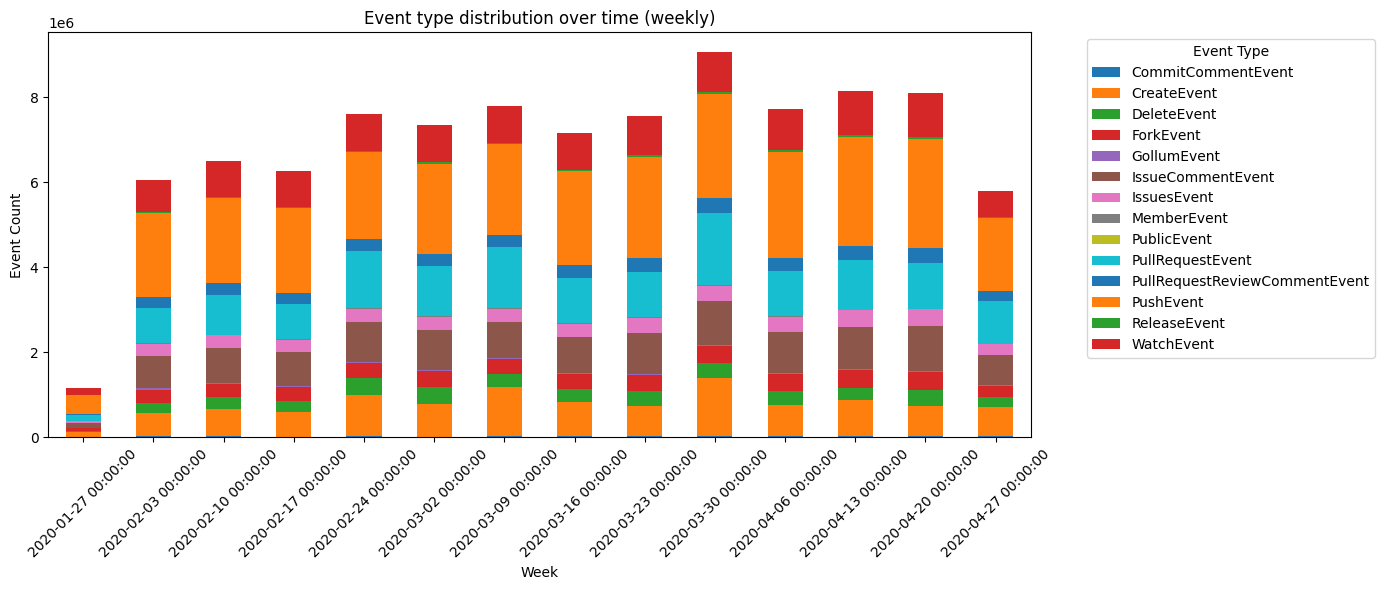

In [ ]:
# plot for event type distributions on weekly basis (needs imrpovement)
event_types_weekly.plot(kind = 'bar', stacked = True, figsize = (14, 6))
plt.title('Event type distribution over time (weekly)')
plt.xlabel('Week')
plt.ylabel('Event Count')
plt.xticks(rotation=45)
plt.legend(title='Event Type', bbox_to_anchor=(1.05, 1), loc= 'upper left')
plt.tight_layout()
plt.show()

The main collaboration events - IssueCommentEvent, PullRequestEvent, PullRequestReviewCommentEvent, IssuesEvent show slight increase in volume from early March to Mid April, especially PRs and comments. This may be said as developers settling into remote workflows. In general, there is a notable rise accross all event types from early Febuary to April. Increase in FortEvents and WatchEvents show some growth in possible exploration of new projects during remote period.

In [ ]:
actor_contributions = df_collab['actor'].value_counts().compute()

[########################################] | 100% Completed | 20m 24s


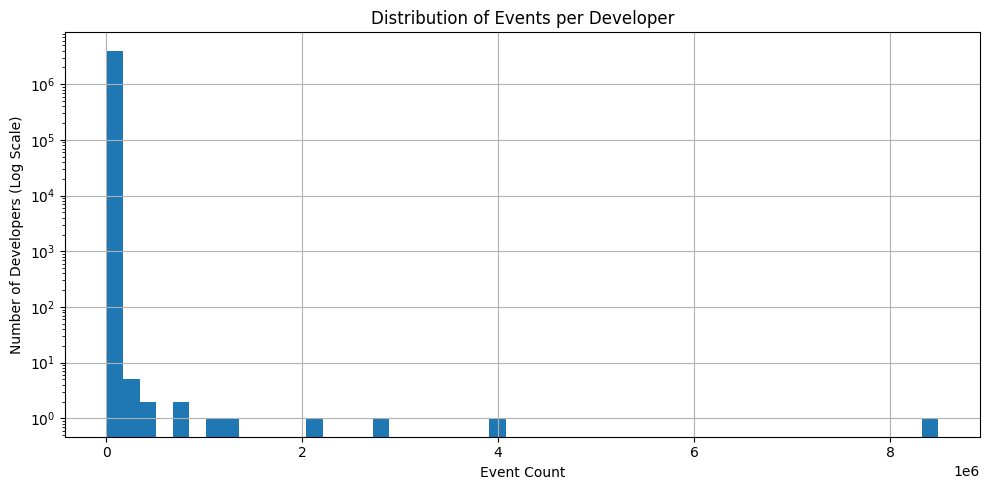

In [ ]:
plt.figure(figsize=(10, 5))
actor_contributions.hist(bins=50, log=True)
plt.title("Distribution of Events per Developer")
plt.xlabel("Event Count")
plt.ylabel("Number of Developers (Log Scale)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
actor_contributions.describe()

,count
count,3997677.0
mean,24.076063
std,5140.299008
min,1.0
25%,1.0
50%,3.0
75%,8.0
max,8493896.0


So, for this project -
PushEvent, PullRequestEvent, IssueCommentEvent, PullRequestReviewCommentEvent, IssuesEvent are useful

In [ ]:
df_feb_apr_20.head(1000).to_csv('feb_apr_sample.csv', index = False)

In [ ]:
# creating a new column to find whether actor is a bot or not
bot_pattern = re.compile(r'(^bot[-_])|([-_]bot([-_]|$))|(\[bot\]$)', re.IGNORECASE)
df_sample = df_feb_apr_20.copy()
df_sample['is_bot'] = df_sample['actor'].apply(lambda x: bool(bot_pattern.search(x))
                                                if isinstance(x, str) else False,
                                               meta=('is_bot', bool))

In [ ]:
print(df_sample['is_bot'].value_counts().compute())

is_bot
True     22167507
False    74080817
Name: count, dtype: int64


From above I can see 23% of total events were triggered by bot accounts

In [ ]:
df_sample[df_sample['is_bot'] == True]['actor'].unique().compute()

,actor
0,cvs-tsk-sec-pr-bot[bot]
0,muse-dev[bot]
1,wolox-organization-manager[bot]
2,getodk-bot
3,sina-bot
...,...
6,snaplogic-uat[bot]
0,sourcery-ai-bot
1,sonarclouddogfood[bot]
2,matt-riley-bot[bot]


In [ ]:
# to find the type of events the bots are doing mostly
df_sample.groupby(['is_bot', 'type']).size().compute()

is_bot  type                         
False   MemberEvent                        139818
        PushEvent                        25598506
True    PullRequestReviewCommentEvent      113766
        GollumEvent                           251
False   PullRequestReviewCommentEvent     3789995
True    ForkEvent                            7399
False   IssueCommentEvent                 8876358
        ReleaseEvent                       331636
        IssuesEvent                       3897061
True    CommitCommentEvent                 227725
False   CommitCommentEvent                 160804
        CreateEvent                       5294128
        DeleteEvent                       2077352
True    PushEvent                         3430198
        DeleteEvent                       2081721
        ReleaseEvent                       106438
False   GollumEvent                        329697
        WatchEvent                       11610695
True    WatchEvent                           1027
False   ForkEvent                         4714767
True    MemberEvent                          3695
        PullRequestEvent                  7600583
False   PullRequestEvent                  7259979
True    IssueCommentEvent                 2933121
        CreateEvent                       5315122
        IssuesEvent                        346461
False   PublicEvent                            21
dtype: int64

In [ ]:
# getting the grouped data
event_counts = df_sample.groupby(['is_bot', 'type']).size().compute().reset_index(name='count')
# pivotting for plotting
pivot_df = event_counts.pivot(index='type', columns='is_bot', values='count').fillna(0)

pivot_df['total'] = pivot_df[True] + pivot_df[False]
pivot_df = pivot_df.sort_values('total', ascending=False).drop(columns='total')


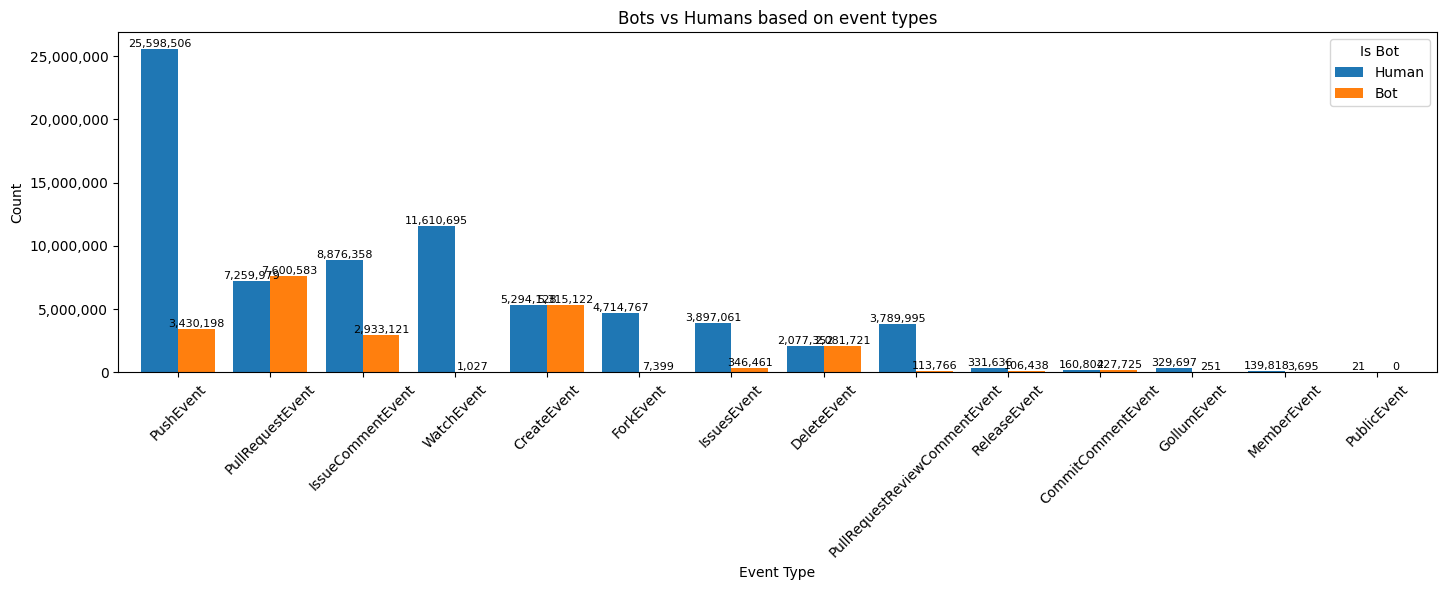

In [ ]:
# plotting
ax = pivot_df.plot(kind='bar', figsize=(14, 6), width=0.8)
plt.title("Bots vs Humans based on event types")
plt.ylabel("Count")
plt.xlabel("Event Type")
plt.xticks(rotation=45)
plt.legend(title='Is Bot', labels=['Human', 'Bot'])
plt.tight_layout()

# to remove scientific notation
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))

for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=8, fmt='{:,.0f}')

plt.show()

References -  
- https://docs.dask.org/en/stable/
- https://networkx.org/documentation/latest/auto_examples/drawing/plot_degree.html#sphx-glr-auto-examples-drawing-plot-degree-py
- https://github.com/networkx/networkx
-